# Testing the CosmoAPI SACC Generation Developement

In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from firecrown.metadata_types import Galaxies, InferredGalaxyZDist, TwoPointHarmonic, TwoPointXY
from firecrown.generators.inferred_galaxy_zdist import ZDistLSSTSRDBin, LinearGrid1D
from firecrown.utils import base_model_to_yaml, base_model_from_yaml
from firecrown.metadata_functions import make_all_photoz_bin_combinations, TwoPointHarmonic, TwoPointReal
import firecrown.likelihood.two_point as tp
from firecrown.modeling_tools import ModelingTools
from firecrown.ccl_factory import CCLFactory
from firecrown.updatable import get_default_params
from firecrown.parameters import ParamsMap
import firecrown

import numpy as np
import matplotlib.pyplot as plt

# this is only needed for now:
from CosmoAPI.two_pt_func import generate_theory, nz_loader, tracer_tools
from CosmoAPI.api_io import load_yaml_file
from CosmoAPI.firecrown_tools import load_systematics_factory, build_modeling_tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
config = load_yaml_file('../test.yaml')
vitor_config = load_yaml_file('../CosmoAPI/two_pt_func/config_yamls/config_3x2pt_.yaml')

In [3]:
ell_test = generate_theory.generate_ell_theta_array(config['probes']['source'], 'ell_bins', dtype=float)
print(len(ell_test))

nzs = nz_loader.load_all_redshift_distr(config)
# process the probes:
two_pt_function, two_pt_probes = tracer_tools.process_probes_load_2pt(config)

128
All nz_type probes have the same function: TwoPointHarmonic
All nz_type probes have the same function: TwoPointHarmonic


In [7]:
tracer_tools.build_twopointxy_combinations(config, nzs)

{'source_source': [TwoPointXY(x=InferredGalaxyZDist(bin_name='source_0', z=array([1.00000000e-04, 1.21361694e-04, 1.42723389e-04, 1.64085083e-04,
         1.85446777e-04, 2.28170166e-04, 2.70893555e-04, 3.56340332e-04,
         4.41787109e-04, 5.27233887e-04, 6.12680664e-04, 6.98127441e-04,
         7.83574219e-04, 9.54467773e-04, 1.12536133e-03, 1.29625488e-03,
         1.46714844e-03, 1.80893555e-03, 2.15072266e-03, 2.49250977e-03,
         2.83429687e-03, 3.51787109e-03, 4.20144531e-03, 4.88501953e-03,
         5.56859375e-03, 6.93574219e-03, 8.30289062e-03, 9.67003906e-03,
         1.10371875e-02, 1.24043359e-02, 1.37714844e-02, 1.51386328e-02,
         1.65057812e-02, 1.78729297e-02, 1.92400781e-02, 2.06072266e-02,
         2.19743750e-02, 2.47086719e-02, 2.74429687e-02, 3.01772656e-02,
         3.29115625e-02, 3.56458594e-02, 3.83801562e-02, 4.11144531e-02,
         4.38487500e-02, 4.93173437e-02, 5.47859375e-02, 6.02545312e-02,
         6.57231250e-02, 7.11917187e-02, 7.66603125

In [51]:
bin_names_nz = sorted([sample.bin_name for sample in nzs])
print(bin_names_nz)

['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4', 'source_0', 'source_1', 'source_2', 'source_3', 'source_4']


In [93]:
def build_twopointxy_combinations2(config_yaml: dict, _distribution_list: list,) -> dict:

    _all_two_point_combinations = {k: [] for k in config_yaml["probe_combinations"].keys()}
    _tracer_combinations = config_yaml["probe_combinations"]

    # Check from the names of the probes if these make sense:
    for k in _all_two_point_combinations.keys():
        tracer1, tracer2 = k.split('_')
        probes = config_yaml['probes'].keys()
        if tracer1 not in probes or tracer2 not in probes:
            raise ValueError(f"Tracer combination {k} has tracers {tracer1} "
                             f"or {tracer2} not in probes {probes}")

    for tracer in _tracer_combinations.keys():
        bin_combinations = _tracer_combinations[tracer]["bin_combinations"]

        if isinstance(bin_combinations, str):
            if bin_combinations == 'all':
                # Generate all combinations
                max_bin = max(int(b.split('_')[-1]) for b in bin_names_nz if tracer.split('_')[0] in b)
                bin_combinations = [(i, j) for i in range(max_bin + 1) for j in range(i, max_bin + 1)]
            elif bin_combinations == 'autos':
                # Generate auto combinations (x = y)
                bins = [int(b.split('_')[-1]) for b in bin_names_nz if tracer.split('_')[0] in b]
                bin_combinations = [[x, x] for x in bins]
            else:
                raise ValueError(f"Unknown bin_combinations value: {bin_combinations}")
        for comb in bin_combinations:
            x = f"{tracer.split("_")[0]}_{str(comb[0])}"
            y = f"{tracer.split("_")[1]}_{str(comb[1])}"
            x_measurement = None
            y_measurement = None
            for sample in _distribution_list:
                if sample.bin_name == x:
                    x_dist = sample
                    x_measurement = next(iter(x_dist.measurements))
                if sample.bin_name == y:
                    y_dist = sample
                    y_measurement = next(iter(y_dist.measurements))
            if x_measurement is not None and y_measurement is not None:
                _all_two_point_combinations[tracer].append(
                    TwoPointXY(x=x_dist, y=y_dist,
                               x_measurement=x_measurement,
                               y_measurement=y_measurement))
    return _all_two_point_combinations

build_twopointxy_combinations(config, nzs)

source_source [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 1), (1, 2), (1, 3), (1, 4), (2, 2), (2, 3), (2, 4), (3, 3), (3, 4), (4, 4)]
source_0 source_0
source_0 source_1
source_0 source_2
source_0 source_3
source_0 source_4
source_1 source_1
source_1 source_2
source_1 source_3
source_1 source_4
source_2 source_2
source_2 source_3
source_2 source_4
source_3 source_3
source_3 source_4
source_4 source_4
lens_lens [[0, 0], [1, 1], [2, 2], [3, 3], [4, 4]]
lens_0 lens_0
lens_1 lens_1
lens_2 lens_2
lens_3 lens_3
lens_4 lens_4
lens_source [[0, 2], [0, 3], [0, 4], [1, 3], [1, 4], [2, 4], [3, 4]]
lens_0 source_2
lens_0 source_3
lens_0 source_4
lens_1 source_3
lens_1 source_4
lens_2 source_4
lens_3 source_4


{'source_source': [TwoPointXY(x=InferredGalaxyZDist(bin_name='source_0', z=array([1.00000000e-04, 1.21361694e-04, 1.42723389e-04, 1.64085083e-04,
         1.85446777e-04, 2.28170166e-04, 2.70893555e-04, 3.56340332e-04,
         4.41787109e-04, 5.27233887e-04, 6.12680664e-04, 6.98127441e-04,
         7.83574219e-04, 9.54467773e-04, 1.12536133e-03, 1.29625488e-03,
         1.46714844e-03, 1.80893555e-03, 2.15072266e-03, 2.49250977e-03,
         2.83429687e-03, 3.51787109e-03, 4.20144531e-03, 4.88501953e-03,
         5.56859375e-03, 6.93574219e-03, 8.30289062e-03, 9.67003906e-03,
         1.10371875e-02, 1.24043359e-02, 1.37714844e-02, 1.51386328e-02,
         1.65057812e-02, 1.78729297e-02, 1.92400781e-02, 2.06072266e-02,
         2.19743750e-02, 2.47086719e-02, 2.74429687e-02, 3.01772656e-02,
         3.29115625e-02, 3.56458594e-02, 3.83801562e-02, 4.11144531e-02,
         4.38487500e-02, 4.93173437e-02, 5.47859375e-02, 6.02545312e-02,
         6.57231250e-02, 7.11917187e-02, 7.66603125

In [14]:
#FIXME: We have to implement this in the yaml
ells = np.unique(np.geomspace(2, 2000, 128))

# process the probes:
two_pt_function, two_pt_probes = tracer_tools.process_probes_load_2pt(config)
# load all the nzs:
nzs = nz_loader.load_all_redshift_distr(config)

# make all two point functions bin combinations:
all_two_point_bins = make_all_photoz_bin_combinations(nzs)
# generate the necessary metadata:
all_two_point_metdata = [two_pt_function(XY=ij, ells=ells) for ij in all_two_point_bins]

# load all the systematics for all probes:
probes = config.get("probes", [])
for p in two_pt_probes:
    probes[p]['loaded_systematics'] = load_systematics_factory(config['probes'][p]['systematics'])

# prepare all the two point functions:
all_two_point_functions = tp.TwoPoint.from_metadata(
    metadata_seq=all_two_point_metdata,
    wl_factory=probes['source']['loaded_systematics'],
    nc_factory=probes['lens']['loaded_systematics'],
)

All nz_type probes have the same function: TwoPointHarmonic
All nz_type probes have the same function: TwoPointHarmonic


In [16]:
for ij in all_two_point_bins:
    print(ij, type(ij))

(source_0, source_0) <class 'firecrown.metadata_types.TwoPointXY'>
(source_0, source_1) <class 'firecrown.metadata_types.TwoPointXY'>
(source_0, source_2) <class 'firecrown.metadata_types.TwoPointXY'>
(source_0, source_3) <class 'firecrown.metadata_types.TwoPointXY'>
(source_0, source_4) <class 'firecrown.metadata_types.TwoPointXY'>
(source_0, lens_0) <class 'firecrown.metadata_types.TwoPointXY'>
(source_0, lens_1) <class 'firecrown.metadata_types.TwoPointXY'>
(source_0, lens_2) <class 'firecrown.metadata_types.TwoPointXY'>
(source_0, lens_3) <class 'firecrown.metadata_types.TwoPointXY'>
(source_0, lens_4) <class 'firecrown.metadata_types.TwoPointXY'>
(source_1, source_1) <class 'firecrown.metadata_types.TwoPointXY'>
(source_1, source_2) <class 'firecrown.metadata_types.TwoPointXY'>
(source_1, source_3) <class 'firecrown.metadata_types.TwoPointXY'>
(source_1, source_4) <class 'firecrown.metadata_types.TwoPointXY'>
(source_1, lens_0) <class 'firecrown.metadata_types.TwoPointXY'>
(source

## Trying with our functions

In [7]:
from CosmoAPI.firecrown_tools import update_missing_keys, extract_per_bin_systematics

In [8]:
config = load_yaml_file('../test.yaml')

In [9]:
per_bin_syst = extract_per_bin_systematics(config)

In [10]:
test_dict = {**config['cosmology'], **per_bin_syst}
print(test_dict)

{'Omega_m': 0.3388, 'A_s': 1.9019e-09, 'n_s': 0.9493, 'Omega_b': 0.04575, 'h': 0.6714, 'w0': -1.0, 'wa': 0.0, 'm_nu': 0.1, 'Neff': 3.044, 'T_CMB': 2.7255, 'Omega_k': 0.0, 'extra_parameters': {'mass_split': 'normal', 'non_linear': True, 'camb': {'halofit_version': 'mead2020'}}, 'source_0_mult_bias': 0.001, 'source_1_mult_bias': 0.001, 'source_2_mult_bias': 0.001, 'source_3_mult_bias': 0.001, 'source_4_mult_bias': 0.001, 'source_0_delta_z': 0.2, 'source_1_delta_z': 0.1, 'source_2_delta_z': 0.1, 'source_3_delta_z': 0.2, 'source_4_delta_z': 0.1, 'lens_0_delta_z': 0.2, 'lens_1_delta_z': 0.1, 'lens_2_delta_z': 0.1, 'lens_3_delta_z': 0.2, 'lens_4_delta_z': 0.1, 'lens_0_bias': 1.0, 'lens_1_bias': 2.0, 'lens_2_bias': 3.0, 'lens_3_bias': 4.0, 'lens_4_bias': 5.0}


In [14]:
alltp_func, alltp_metadata = generate_theory.prepare_2pt_functions(config)

All nz_type probes have the same function: TwoPointHarmonic
All nz_type probes have the same function: TwoPointHarmonic
Loading systematics for probe source
Loading systematics for probe lens


In [15]:
len(alltp_metadata)

110

In [109]:
tools = build_modeling_tools(config)

In [115]:
default_values = get_default_params(tools, all_two_point_functions)
print(default_values)
firecrown_params = update_missing_keys(test_dict, default_values)

{'source_3_delta_z': 0.0, 'T_CMB': 2.7255, 'source_3_mult_bias': 1.0, 'lens_0_alphaz': 0.0, 'lens_3_bias': 1.5, 'source_1_mult_bias': 1.0, 'Omega_b': 0.05, 'lens_4_delta_z': 0.0, 'h': 0.67, 'A_s': 2.1e-09, 'lens_2_z_piv': 0.5, 'lens_2_bias': 1.5, 'lens_2_delta_z': 0.0, 'w0': -1.0, 'Omega_c': 0.25, 'source_4_mult_bias': 1.0, 'Omega_k': 0.0, 'source_0_delta_z': 0.0, 'lens_4_bias': 1.5, 'lens_0_delta_z': 0.0, 'Neff': 3.044, 'lens_0_bias': 1.5, 'lens_0_alphag': 1.0, 'lens_2_alphaz': 0.0, 'source_1_delta_z': 0.0, 'source_2_delta_z': 0.0, 'wa': 0.0, 'alphaz': 0.0, 'lens_1_z_piv': 0.5, 'n_s': 0.96, 'lens_3_delta_z': 0.0, 'lens_4_alphag': 1.0, 'source_0_mult_bias': 1.0, 'lens_4_z_piv': 0.5, 'lens_0_z_piv': 0.5, 'z_piv': 0.5, 'lens_2_alphag': 1.0, 'lens_1_alphaz': 0.0, 'm_nu': [], 'source_2_mult_bias': 1.0, 'lens_1_delta_z': 0.0, 'lens_1_alphag': 1.0, 'lens_1_bias': 1.5, 'ia_bias': 0.5, 'lens_3_z_piv': 0.5, 'lens_4_alphaz': 0.0, 'source_4_delta_z': 0.0, 'lens_3_alphag': 1.0, 'lens_3_alphaz': 0.

In [116]:
firecrown_params

{'Omega_m': 0.3388,
 'A_s': 1.9019e-09,
 'n_s': 0.9493,
 'Omega_b': 0.04575,
 'h': 0.6714,
 'w0': -1.0,
 'wa': 0.0,
 'm_nu': 0.1,
 'Neff': 3.044,
 'T_CMB': 2.7255,
 'Omega_k': 0.0,
 'extra_parameters': {'mass_split': 'normal',
  'non_linear': True,
  'camb': {'halofit_version': 'mead2020'}},
 'source_0_mult_bias': 0.001,
 'source_1_mult_bias': 0.001,
 'source_2_mult_bias': 0.001,
 'source_3_mult_bias': 0.001,
 'source_4_mult_bias': 0.001,
 'source_0_delta_z': 0.2,
 'source_1_delta_z': 0.1,
 'source_2_delta_z': 0.1,
 'source_3_delta_z': 0.2,
 'source_4_delta_z': 0.1,
 'lens_0_delta_z': 0.2,
 'lens_1_delta_z': 0.1,
 'lens_2_delta_z': 0.1,
 'lens_3_delta_z': 0.2,
 'lens_4_delta_z': 0.1,
 'lens_0_bias': 1.0,
 'lens_1_bias': 2.0,
 'lens_2_bias': 3.0,
 'lens_3_bias': 4.0,
 'lens_4_bias': 5.0,
 'z_piv': 0.5,
 'Omega_c': 0.25,
 'ia_bias': 0.5,
 'alphaz': 0.0,
 'lens_0_alphaz': 0.0,
 'lens_2_z_piv': 0.5,
 'lens_0_alphag': 1.0,
 'lens_2_alphaz': 0.0,
 'lens_1_z_piv': 0.5,
 'lens_4_alphag': 1.0,


In [117]:
default_values

{'source_3_delta_z': 0.0,
 'T_CMB': 2.7255,
 'source_3_mult_bias': 1.0,
 'lens_0_alphaz': 0.0,
 'lens_3_bias': 1.5,
 'source_1_mult_bias': 1.0,
 'Omega_b': 0.05,
 'lens_4_delta_z': 0.0,
 'h': 0.67,
 'A_s': 2.1e-09,
 'lens_2_z_piv': 0.5,
 'lens_2_bias': 1.5,
 'lens_2_delta_z': 0.0,
 'w0': -1.0,
 'Omega_c': 0.25,
 'source_4_mult_bias': 1.0,
 'Omega_k': 0.0,
 'source_0_delta_z': 0.0,
 'lens_4_bias': 1.5,
 'lens_0_delta_z': 0.0,
 'Neff': 3.044,
 'lens_0_bias': 1.5,
 'lens_0_alphag': 1.0,
 'lens_2_alphaz': 0.0,
 'source_1_delta_z': 0.0,
 'source_2_delta_z': 0.0,
 'wa': 0.0,
 'alphaz': 0.0,
 'lens_1_z_piv': 0.5,
 'n_s': 0.96,
 'lens_3_delta_z': 0.0,
 'lens_4_alphag': 1.0,
 'source_0_mult_bias': 1.0,
 'lens_4_z_piv': 0.5,
 'lens_0_z_piv': 0.5,
 'z_piv': 0.5,
 'lens_2_alphag': 1.0,
 'lens_1_alphaz': 0.0,
 'm_nu': [],
 'source_2_mult_bias': 1.0,
 'lens_1_delta_z': 0.0,
 'lens_1_alphag': 1.0,
 'lens_1_bias': 1.5,
 'ia_bias': 0.5,
 'lens_3_z_piv': 0.5,
 'lens_4_alphaz': 0.0,
 'source_4_delta_z': 

In [91]:
#tools = ModelingTools(ccl_factory=CCLFactory(require_nonlinear_pk=True))
default_values = get_default_params(tools, all_two_point_functions)
params = ParamsMap(firecrown_params)

tools.update(params)
tools.prepare()
all_two_point_functions.update(params)

MissingSamplerParameterError: The parameter `source_2_mult_bias` is required to update something in this likelihood.
It should have been supplied by the sampling framework.
The object being updated was:
source_2_mult_bias


In [92]:
default_values

{'source_3_delta_z': 0.0,
 'T_CMB': 2.7255,
 'source_3_mult_bias': 1.0,
 'lens_3_bias': 1.5,
 'source_1_mult_bias': 1.0,
 'Omega_b': 0.05,
 'lens_4_delta_z': 0.0,
 'h': 0.67,
 'A_s': 2.1e-09,
 'lens_2_bias': 1.5,
 'lens_2_delta_z': 0.0,
 'w0': -1.0,
 'Omega_c': 0.25,
 'source_4_mult_bias': 1.0,
 'Omega_k': 0.0,
 'source_0_delta_z': 0.0,
 'lens_4_bias': 1.5,
 'lens_0_delta_z': 0.0,
 'Neff': 3.044,
 'lens_0_bias': 1.5,
 'source_1_delta_z': 0.0,
 'source_2_delta_z': 0.0,
 'wa': 0.0,
 'alphaz': 0.0,
 'n_s': 0.96,
 'lens_3_delta_z': 0.0,
 'source_0_mult_bias': 1.0,
 'z_piv': 0.5,
 'm_nu': [],
 'source_2_mult_bias': 1.0,
 'lens_1_delta_z': 0.0,
 'lens_1_bias': 1.5,
 'ia_bias': 0.5,
 'source_4_delta_z': 0.0}

In [11]:
two_point0 = all_two_point_functions[0]
meta0 = all_two_point_metdata[0]
tv0 = two_point0.compute_theory_vector(tools)

In [12]:
import pandas as pd
two_point_pd_list = []
for two_point, meta in zip(all_two_point_functions, all_two_point_metdata):
    two_point_pd_list.append(
        pd.DataFrame(
            {
                "ell": two_point.ells,
                "Cell": np.abs(two_point.compute_theory_vector(tools)),
                "bin-x": meta.XY.x.bin_name,
                "bin-y": meta.XY.y.bin_name,
                "measurement": meta.get_sacc_name(),
            }
        )
    )

In [13]:
two_point_pd_list

[             ell          Cell     bin-x     bin-y         measurement
 0       2.000000  2.062488e-08  source_0  source_0  galaxy_shear_cl_ee
 1       2.111796  2.150840e-08  source_0  source_0  galaxy_shear_cl_ee
 2       2.229842  2.228341e-08  source_0  source_0  galaxy_shear_cl_ee
 3       2.354486  2.295176e-08  source_0  source_0  galaxy_shear_cl_ee
 4       2.486098  2.351573e-08  source_0  source_0  galaxy_shear_cl_ee
 ..           ...           ...       ...       ...                 ...
 123  1608.947253  2.188825e-11  source_0  source_0  galaxy_shear_cl_ee
 124  1698.884500  1.971539e-11  source_0  source_0  galaxy_shear_cl_ee
 125  1793.849076  1.773986e-11  source_0  source_0  galaxy_shear_cl_ee
 126  1894.122000  1.594651e-11  source_0  source_0  galaxy_shear_cl_ee
 127  2000.000000  1.432087e-11  source_0  source_0  galaxy_shear_cl_ee
 
 [128 rows x 5 columns],
              ell          Cell     bin-x     bin-y         measurement
 0       2.000000  2.918190e-08  sour

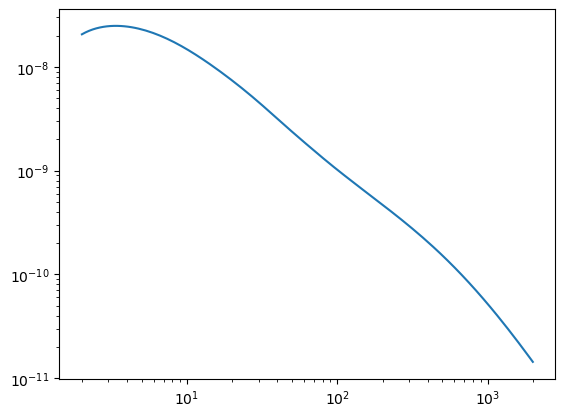

In [14]:
plt.loglog(ells, tv0)

In [15]:
ells

array([   2.        ,    2.11179639,    2.22984199,    2.35448614,
          2.48609766,    2.62506603,    2.77180248,    2.92674123,
          3.09034079,    3.26308526,    3.44548583,    3.63808227,
          3.8414445 ,    4.05617431,    4.28290713,    4.5223139 ,
          4.77510308,    5.04202273,    5.32386269,    5.621457  ,
          5.9356863 ,    6.26748045,    6.61782129,    6.98774555,
          7.37834791,    7.79078423,    8.22627501,    8.68610893,
          9.17164673,    9.68432522,   10.22566152,   10.79725753,
         11.40080474,   12.03808914,   12.71099658,   13.42151834,
         14.17175698,   14.96393261,   15.80038942,   16.68360267,
         17.61618593,   18.60089892,   19.64065558,   20.73853277,
         21.8977793 ,   23.12182563,   24.41429393,   25.77900888,
         27.22000893,   28.74155828,   30.3481595 ,   32.04456682,
         33.83580024,   35.72716038,   37.72424414,   39.83296128,
         42.05955189,   44.4106049 ,   46.89307753,   49.51431